In [1]:
!pip install yfinance pandas_ta xgboost matplotlib pandas numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.3/240.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 18.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninsta

 ROBUST LONG–SHORT ML STRATEGY (2025)
Final Capital : ₹1,042,332
Total Return  : 4.23%
Sharpe Ratio  : 0.87


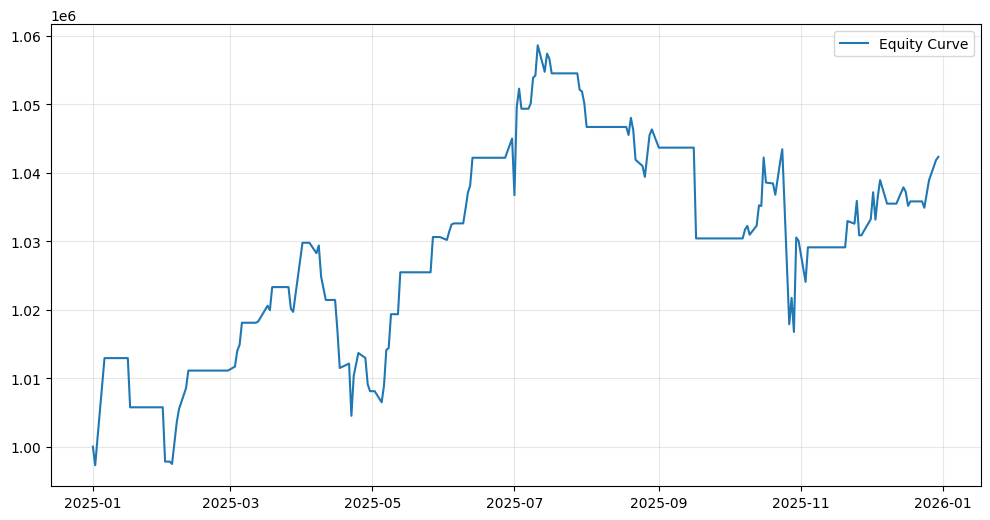

In [11]:
# ============================================================
# ROBUST LONG–SHORT ML STRATEGY (XGB + RF ENSEMBLE)
# ============================================================

import yfinance as yf
import pandas as pd
import numpy as np
import pandas_ta as ta
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
STOCKS = ["RELIANCE.NS", "TCS.NS", "SBIN.NS", "HDFCBANK.NS", "ITC.NS"]
INDEX = "^NSEI"
START_DATE = "2013-01-01"
END_DATE = "2025-12-31"

INITIAL_CAPITAL = 1_000_000
RISK_PER_TRADE = 0.005
MAX_POSITIONS = 3

ATR_MULT = 1.1
PROFIT_TARGET = 0.02
MAX_HOLD_DAYS = 4

FEATURES = ["RSI", "Z", "ADX", "ATR"]
# ---------------------------------------


# ================= DATA =================
stock_data = {}
for s in STOCKS:
    df = yf.download(s, start=START_DATE, end=END_DATE,
                     auto_adjust=True, progress=False)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    stock_data[s] = df[["Open", "High", "Low", "Close"]].dropna()

nifty = yf.download(INDEX, start=START_DATE, end=END_DATE,
                    auto_adjust=True, progress=False)
if isinstance(nifty.columns, pd.MultiIndex):
    nifty.columns = nifty.columns.get_level_values(0)
nifty = nifty[["Close"]].dropna()


# ============== FEATURES ===============
processed = {}
for s, df in stock_data.items():
    t = df.copy()
    t["RSI"] = ta.rsi(t["Close"], 14)
    t["ATR"] = ta.atr(t["High"], t["Low"], t["Close"], 14)
    t["MA20"] = t["Close"].rolling(20).mean()
    t["STD20"] = t["Close"].rolling(20).std()
    t["Z"] = (t["Close"] - t["MA20"]) / t["STD20"]
    adx = ta.adx(t["High"], t["Low"], t["Close"], 14)
    t["ADX"] = adx.iloc[:, 0]
    t["Target"] = (t["Close"].shift(-3) > t["Close"] * 1.005).astype(int)
    processed[s] = t.dropna()


# ============== TRAIN MODELS ============
models = {}

for s in STOCKS:
    train = processed[s].loc["2014-01-01":"2024-12-31"]
    X, y = train[FEATURES], train["Target"]

    xgb_model = xgb.XGBClassifier(
        n_estimators=150, max_depth=3, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        verbosity=0, random_state=42
    )
    rf_model = RandomForestClassifier(
        n_estimators=300, max_depth=6,
        min_samples_leaf=20, random_state=42
    )

    xgb_model.fit(X, y)
    rf_model.fit(X, y)

    models[s] = (xgb_model, rf_model)


# ============== TRADING =================
cash = INITIAL_CAPITAL
portfolio = {}
equity = []

nifty_2025 = nifty.loc["2025-01-01":"2025-12-31"]

for date in nifty_2025.index:

    total = cash
    for s, pos in portfolio.items():
        total += pos["qty"] * stock_data[s].loc[date, "Close"] * pos["dir"]
    equity.append(total)

    for s in STOCKS:
        if date not in processed[s].index:
            continue

        row = processed[s].loc[date]
        price = stock_data[s].loc[date, "Close"]

        # EXIT
        if s in portfolio:
            pos = portfolio[s]
            pos["days"] += 1
            if (
                (pos["dir"] == 1 and (price <= pos["sl"] or price >= pos["tp"])) or
                (pos["dir"] == -1 and (price >= pos["sl"] or price <= pos["tp"])) or
                pos["days"] >= MAX_HOLD_DAYS
            ):
                cash += pos["qty"] * price * pos["dir"]
                del portfolio[s]
            continue

        if len(portfolio) >= MAX_POSITIONS:
            continue

        xgb_m, rf_m = models[s]
        probs = (
            xgb_m.predict_proba(pd.DataFrame([row[FEATURES]]))[0][1] +
            rf_m.predict_proba(pd.DataFrame([row[FEATURES]]))[0][1]
        ) / 2

        risk_amt = cash * RISK_PER_TRADE

        # LONG
        if row["Z"] < -1.5 and probs > 0.60:
            sl = price - ATR_MULT * row["ATR"]
            qty = int(risk_amt / (price - sl))
            if qty > 0:
                cash -= qty * price
                portfolio[s] = {"qty": qty, "sl": sl,
                                "tp": price * (1 + PROFIT_TARGET),
                                "dir": 1, "days": 0}

        # SHORT
        elif row["Z"] > 1.5 and probs < 0.40:
            sl = price + ATR_MULT * row["ATR"]
            qty = int(risk_amt / (sl - price))
            if qty > 0:
                cash += qty * price
                portfolio[s] = {"qty": qty, "sl": sl,
                                "tp": price * (1 - PROFIT_TARGET),
                                "dir": -1, "days": 0}


# ============== RESULTS =================
equity_series = pd.Series(equity, index=nifty_2025.index)
returns = equity_series.pct_change().dropna()

sharpe = np.sqrt(252) * returns.mean() / returns.std()
ret = (equity_series.iloc[-1] / INITIAL_CAPITAL - 1) * 100

print("=" * 50)
print(" ROBUST LONG–SHORT ML STRATEGY (2025)")
print("=" * 50)
print(f"Final Capital : ₹{equity_series.iloc[-1]:,.0f}")
print(f"Total Return  : {ret:.2f}%")
print(f"Sharpe Ratio  : {sharpe:.2f}")
print("=" * 50)

plt.figure(figsize=(12,6))
plt.plot(equity_series, label="Equity Curve")
plt.grid(alpha=0.3)
plt.legend()
plt.show()
